In [1]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import random
from transformers import AutoTokenizer, PretrainedConfig
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    Normalize,
    InterpolationMode,
)
import numpy as np
# import AutoencoderKL
from diffusers import (
    AutoencoderKL,
)

# Examples of images and prompts

In [6]:
# get healthy images directory path
omid_directory = repo_path / 'data/images/breast40k_RGB_healthy'
# get metadata json path
omid_json_path = omid_directory / 'metadata.jsonl'
# read json file
omid_json = pd.read_json(omid_json_path, lines=True)
omid_json

,file_name,prompt
0,1.2.826.0.1.3680043.9.3218.1.1.392312237.1414....,a mammogram in MLO view with medium area
1,1.2.826.0.1.3680043.9.3218.1.1.392312237.1414....,a mammogram in CC view with medium area
2,1.2.826.0.1.3680043.9.3218.1.1.392312237.1414....,a mammogram in MLO view with medium area
3,1.2.826.0.1.3680043.9.3218.1.1.392312237.1414....,a mammogram in MLO view with medium area
4,1.2.826.0.1.3680043.9.3218.1.1.392312237.1414....,a mammogram in CC view with medium area
...,...,...
33638,1.2.826.0.1.3680043.9.3218.1.1.1405750.1758.15...,a mammogram in CC view with medium area
33639,1.2.826.0.1.3680043.9.3218.1.1.1405750.1758.15...,a mammogram in CC view with medium area
33640,1.2.826.0.1.3680043.9.3218.1.1.1405750.1758.15...,a mammogram in MLO view with medium area
33641,1.2.826.0.1.3680043.9.3218.1.1.3854251.1387.15...,a mammogram in MLO view with small area


OMID-H small size example

a mammogram in CC view with big area


(-0.5, 511.5, 511.5, -0.5)

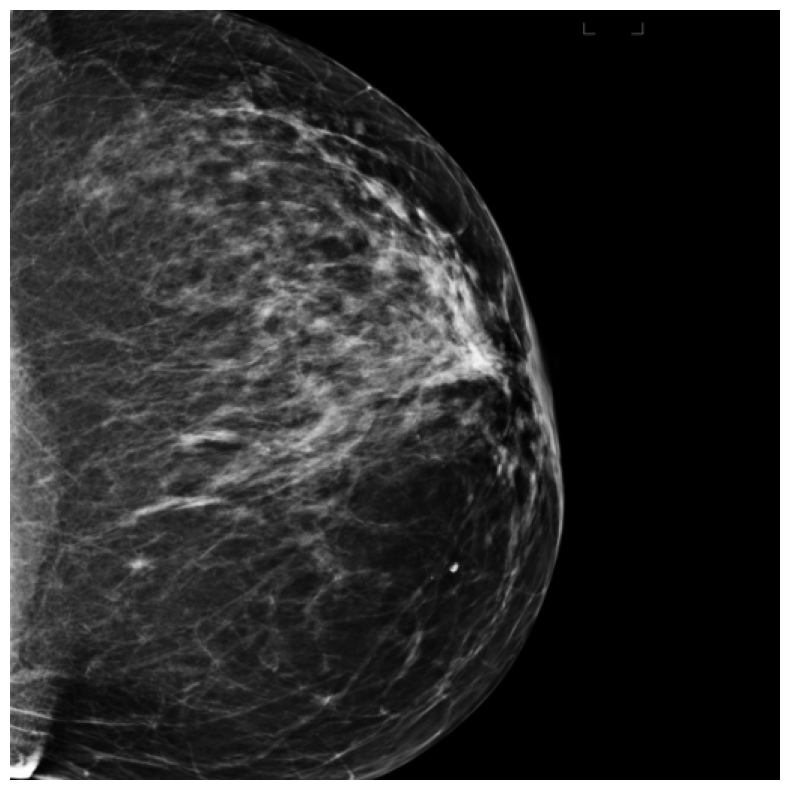

In [42]:
# filter rows of prompt that include the "small area"
small_area = omid_json[omid_json['prompt'].str.contains('big area')]
num = 3064
image_name, image_prompt = small_area.iloc[num].file_name, small_area.iloc[num].prompt
# read image using PIL
image = Image.open(omid_directory / image_name)
# show image
plt.figure(figsize=(10,10))
plt.imshow(image)
print(image_prompt)
# remove axis
plt.axis('off')

In [45]:
# get healthy images directory path
vindr_directory = repo_path / 'data/vindr-mammo/images/siemens15k_RGB_healthy'
# get metadata json path
vindr_json_path = vindr_directory / 'metadata.jsonl'
# read json file
vindr_json = pd.read_json(vindr_json_path, lines=True)

a mammogram in MLO view with very high density


(-0.5, 511.5, 511.5, -0.5)

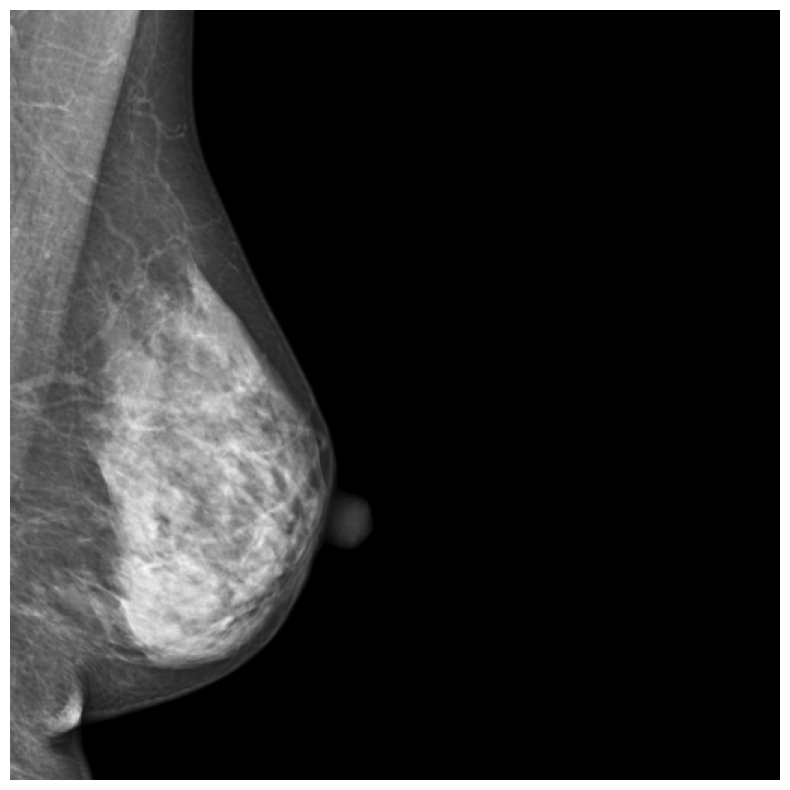

In [54]:
# filter rows of prompt that include the "small area"
density = vindr_json[vindr_json['prompt'].str.contains('very high density')]
num = 5
image_name, image_prompt = density.iloc[num].file_name, density.iloc[num].prompt
# read image using PIL
image = Image.open(vindr_directory / image_name)
# show image
plt.figure(figsize=(10,10))
plt.imshow(image)
print(image_prompt)
# remove axis
plt.axis('off')

# Examples of lesion mammograms and bounding boxes

(-0.5, 511.5, 511.5, -0.5)

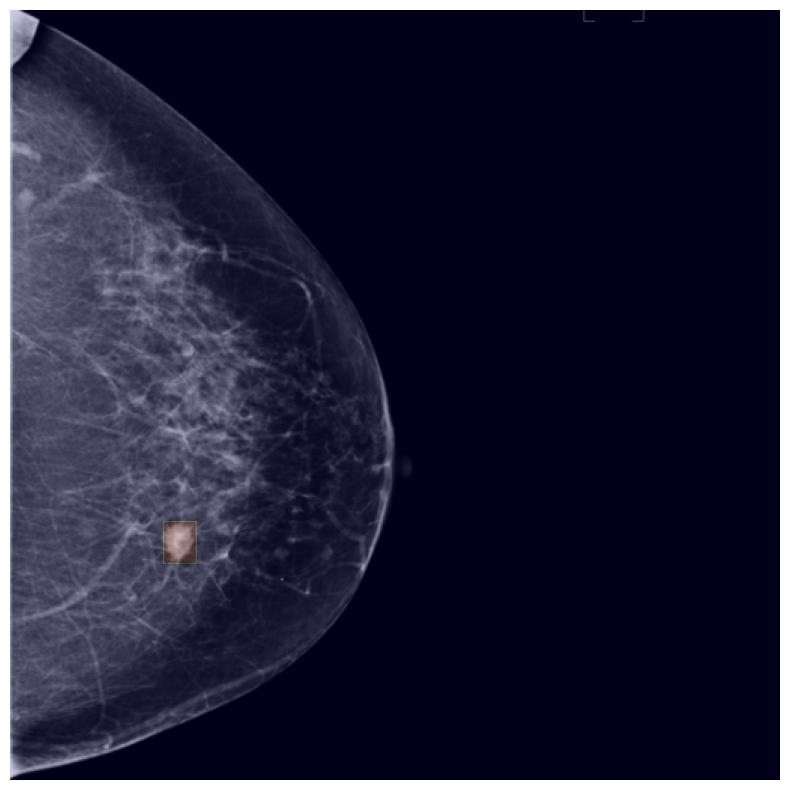

In [34]:
# paths
omid_images_dir = repo_path / 'data/images/breast40k_RGB_wlesions'
omid_masks_dir = repo_path / 'data/masks/breast40k_RGB_wlesions'

# get one random png file from the image dir
# image_name = random.choice(os.listdir(omid_images_dir))
# get all the files names in the image dir
image_names = os.listdir(omid_images_dir)
image_name = image_names[0] # one example
# read image using PIL
image = Image.open(omid_images_dir / image_name)
# read mask using PIL
mask = Image.open(omid_masks_dir / image_name)

# show image and mask overlayed
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.imshow(mask, alpha=0.2, cmap='jet')
# remove axis
plt.axis('off')

# Example of latent image

Text(0.5, 1.0, 'Reconstructed image')

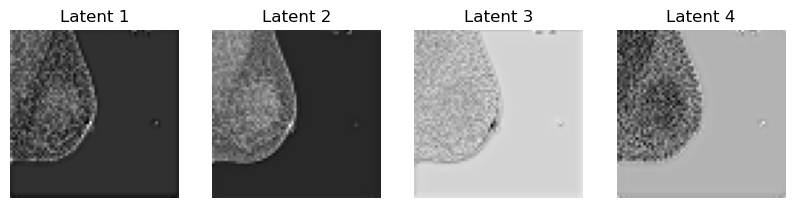

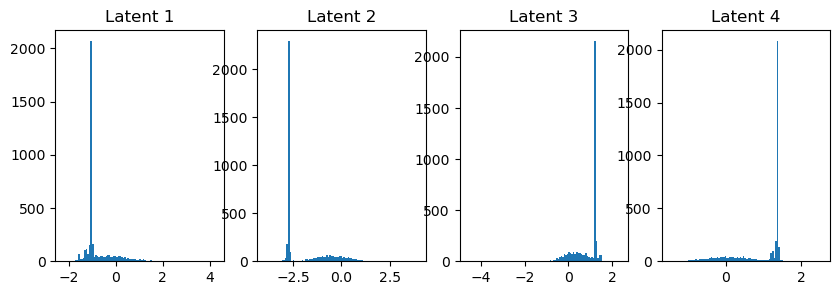

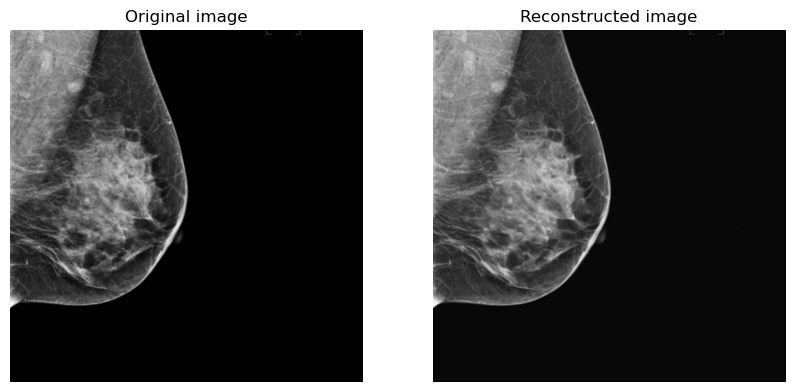

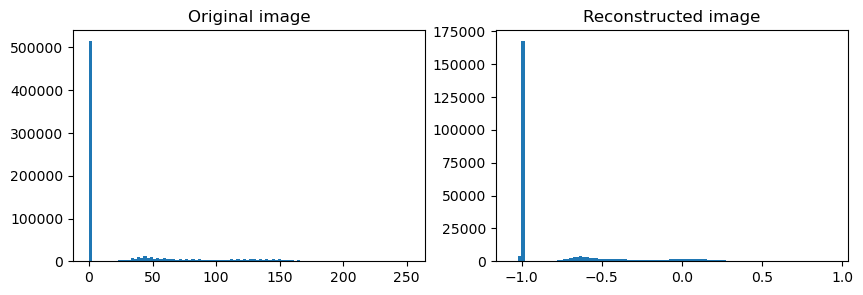

In [20]:
# first we read an example of the latent images
latent_dir = repo_path / 'data/images/breast10p_latents'
image_dir = repo_path / 'data/images/breast10p_RGB'

# load the vae
vae=AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder="vae", revision='fp16')# send vae to gpu
vae.requires_grad_(False)
vae.cuda()

#preprocessing for the image
preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        ToFloat32Tensor(),  # Convert to tensor (0, 1)
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]

# get the name of only the files with pt formal
latent_files = [name for name in os.listdir(latent_dir) if name.endswith('.pt')]
# example
latent_file = latent_files[11]
latent_name = Path(latent_file).stem
# read pt file
latent = torch.load(latent_dir / latent_file)
# load analogous imae
image = Image.open(image_dir / f'{latent_name}.png')

# show the 4 latents
fig, axs = plt.subplots(1,4, figsize=(10,10))
for i, ax in enumerate(axs):
    ax.imshow(latent[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Latent {i+1}')
# show histograms
fig, axs = plt.subplots(1,4, figsize=(10,3))
for i, ax in enumerate(axs):
    ax.hist(latent[i].flatten(), bins=100)
    ax.set_title(f'Latent {i+1}')

# decode
pixels = latent.unsqueeze(0) / vae.config.scaling_factor
pixels = pixels.cuda()
# get orignal image
pixels = vae.decode(pixels).sample
pixels = pixels.cpu().detach().numpy()
# plot original image
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(pixels[0][0], cmap='gray')
axs[1].set_title('Reconstructed image')
# remove axis
for ax in axs:
    ax.axis('off')
# show histograms
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].hist(np.asanyarray(image).flatten(), bins=100)
axs[0].set_title('Original image')
axs[1].hist(pixels[0][0].flatten(), bins=100)
axs[1].set_title('Reconstructed image')